In [12]:
# 모듈 임포트
import os
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
# 경로 설정
%cd ../Covid19-dataset/

c:\Users\User\Desktop\보경\졸업논문(생체의공)\Covid19-dataset


Dataloader 구현

In [14]:
# Custom Dataset 구현
from numpy import float32


class CustomDataset(Dataset):
    def readData(self):
        all_images = []
        all_labels = []
        
        class_names = os.walk(self.dataset_path).__next__()[1]
        
        for idx,class_name in enumerate(class_names):
            img_dir = os.path.join(self.dataset_path,class_name)
            img_names = os.walk(img_dir).__next__()[2]
            print('class name: {}, label: {}, num_images: {}'.format(class_name, idx, len(img_names)))
            
            for img_file in img_names:
                img_path = os.path.join(img_dir,img_file)
                image = Image.open(img_path)
                if image is not None:
                    all_images.append(img_path)
                    all_labels.append(idx)
                    
        return all_images, all_labels, len(all_images), len(class_names)
        
    def __init__(self, dataset_path, transforms=transforms.Resize((256,256))):
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.images, self.labels, self.num_images, self.num_classes = self.readData()
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        # if label==0:
        #     label = [1,0,0]
        # elif label==1:
        #     label = [0,1,0]
        # else:
        #     label = [0,0,1]
        # label = np.array(label,dtype=float32)
        image = Image.open(image)
        image = image.convert('L') # gray scale
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return {'image':image, 'label':label}
    
    def __len__(self):
        return self.num_images
        

데이터 시각화

check test dataset...
class name: Covid, label: 0, num_images: 26
class name: Normal, label: 1, num_images: 20
class name: Viral Pneumonia, label: 2, num_images: 20
test size: 66


check total dataset(train + val)...
class name: Covid, label: 0, num_images: 111
class name: Normal, label: 1, num_images: 70
class name: Viral Pneumonia, label: 2, num_images: 70


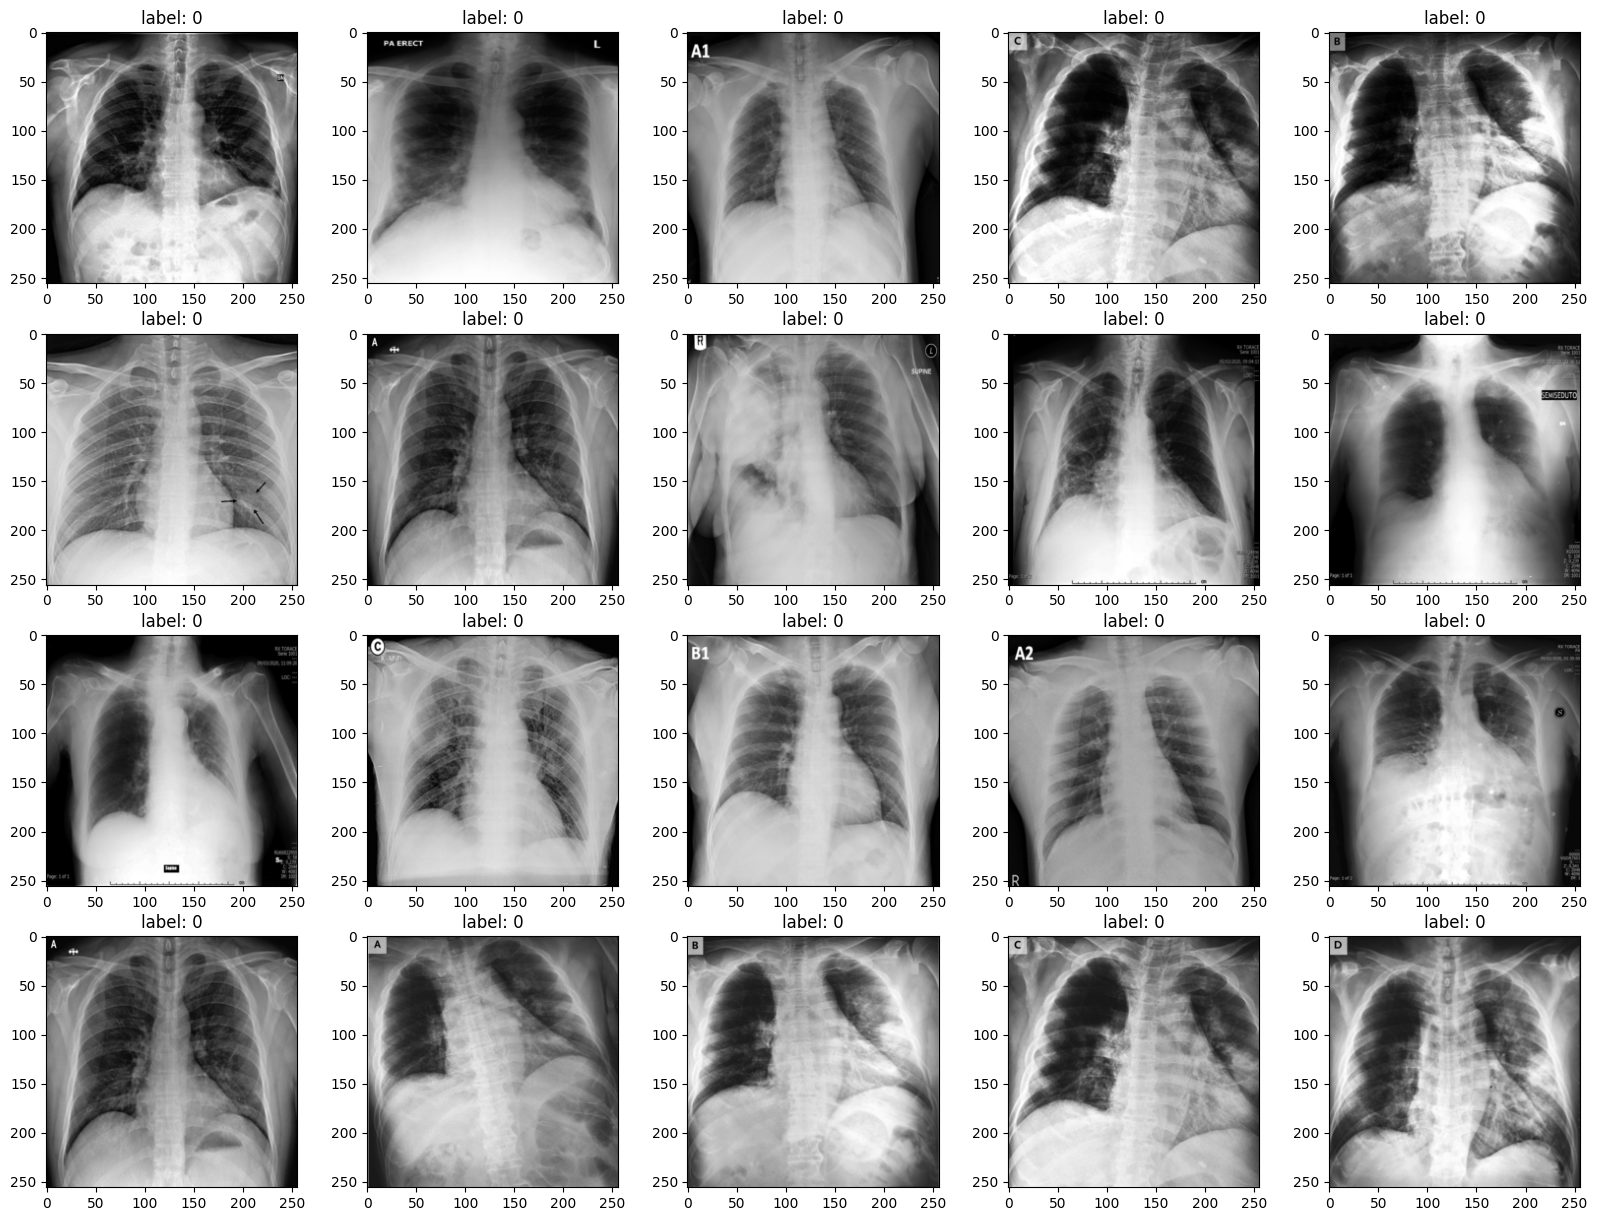

In [15]:
# 데이터 시각화
print('check test dataset...')
test_transforms = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_dataset = CustomDataset('./test',test_transforms)
print('test size: {}'.format(test_dataset.num_images))
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

plt.figure(figsize=(20,15))
to_image = transforms.ToPILImage()
for item in test_loader:
    images = item['image']
    labels = item['label']
    
    for idx, img in enumerate(images):
        img = to_image(img)
        plt.subplot(4,5,idx+1)
        plt.title('label: {}'.format(labels[idx]))
        plt.imshow(img,cmap='gray')
    
    break


print('\n')
print('check total dataset(train + val)...')
train_transforms=transforms.Compose([transforms.Resize((256,256)),transforms.RandomRotation(10),transforms.ToTensor()])
total_dataset = CustomDataset('./train', train_transforms)


In [5]:
# 데이터셋 분할
train_size=int(total_dataset.num_images*0.9)
val_size=total_dataset.num_images-train_size

print('train size: {}, val size: {}'.format(train_size, val_size))

train_dataset, val_dataset=random_split(total_dataset,[train_size, val_size],generator=torch.Generator().manual_seed(42))

train size: 225, val size: 26


모델 환경 설정

In [6]:
from torchvision import models
import ssl
import torchsummary

ssl._create_default_https_context = ssl._create_unverified_context

# 모델 불러오기. ImageNet pre-trained vgg16
# model=models.vgg16(pretrained=True)
# model.features[0]=nn.Conv2d(1,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))

# num_classes=total_dataset.num_classes
# avg_pooling=nn.AdaptiveAvgPool2d(output_size=(1,1))
# model.avgpool = avg_pooling
# vgg_classifier=nn.Sequential(
#     nn.Linear(in_features=512,out_features=256,bias=True),
#     nn.ReLU(),
#     nn.Dropout(p=0.5,inplace=False),
#     nn.Linear(in_features=256,out_features=256,bias=True),
#     nn.ReLU(),
#     nn.Dropout(p=0.5,inplace=False),
#     nn.Linear(in_features=256,out_features=num_classes)
# )
# model.classifier=vgg_classifier
# print(model)

PATH="../Covid19_image_classification_Kaggle/models/"
model = torch.load(PATH+'cee_weights2/model_52.pt')
model.load_state_dict(torch.load(PATH+'cee_weights2/model_state_52.pt'))
checkpoint = torch.load(PATH+'cee_weights2/min_all_52.tar')
model.load_state_dict(checkpoint['model'])


# 하이퍼파라미터 설정
hy_batch=16
hy_epoch=60
hy_lr=0.00001
optimizer=torch.optim.Adam(model.parameters(),lr=hy_lr)
nSamples = [111,70,70]
Weights1 = [1 - (x / sum(nSamples)) for x in nSamples]
Weights1 = torch.FloatTensor(Weights1)
Weights2 = [0.4477,0.7611,0.7211]
Weights2 = torch.FloatTensor(Weights2)
Weights3 = [0.4377,0.7611,0.7611]
Weights3 = torch.FloatTensor(Weights3)

train_loader = DataLoader(train_dataset, batch_size=hy_batch, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hy_batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hy_batch, shuffle=False)


Focal Loss

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss,self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma*ce_loss).mean()
        
        return focal_loss

모듈 구현

In [7]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    crit = nn.CrossEntropyLoss(weight=Weights3)
    sum_loss = 0

    for item in dataloader:
        images = item['image']
        labels = item['label']
        
        outputs = model(images)
        loss = crit(outputs, labels)

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        sum_loss += loss.item()*len(images)

    return sum_loss / len(dataloader.dataset)

def val_epoch(model, dataloader):
    model.eval()
    crit = nn.CrossEntropyLoss(weight=Weights3)
    sum_loss = 0
    correct = 0
    total = len(dataloader.dataset)

    with torch.no_grad():
        for item in dataloader:
            images = item['image']
            labels = item['label']

            outputs = model(images)
            loss = crit(outputs, labels)

            sum_loss += loss.item()*len(images)
            _, predict = torch.max(outputs.data,1)
            # labels = np.argmax(labels,axis=1)
            correct += (predict==labels).sum().item()

        accuracy = correct/total * 100

        return sum_loss/len(dataloader.dataset), accuracy
    

모델 훈련

In [8]:

all_train_loss=[]
all_val_loss=[]
all_val_acc=[]

min_loss=np.Inf
base = 0

for e in range(base,hy_epoch):
    print('epoch {}/{}...'.format(e+1,hy_epoch))
    train_loss=train_epoch(model,train_loader,optimizer)
    val_loss, val_acc=val_epoch(model,val_loader)
    print(
        '  * training loss = {:.6f}, validation loss = {:.6f}, val_acc = {:.6f}%'
        .format(train_loss, val_loss, val_acc)
    )
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if val_loss < min_loss:
        min_loss=val_loss
        print('  * best validation loss')
        torch.save(model,PATH+'cee_weights3/model_{}.pt'.format(e+1))
        torch.save(model.state_dict(),PATH+'cee_weights3/model_state_{}.pt'.format(e+1))
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict()
        },PATH+'cee_weights3/min_all_{}.tar'.format(e+1))

    

epoch 1/60...
  * training loss = 0.000900, validation loss = 0.351757, val_acc = 96.153846%
  * best validation loss
epoch 2/60...
  * training loss = 0.000952, validation loss = 0.000124, val_acc = 100.000000%
  * best validation loss
epoch 3/60...
  * training loss = 0.000631, validation loss = 0.340181, val_acc = 96.153846%
epoch 4/60...
  * training loss = 0.000153, validation loss = 0.000063, val_acc = 100.000000%
  * best validation loss
epoch 5/60...
  * training loss = 0.000607, validation loss = 0.025950, val_acc = 100.000000%
epoch 6/60...
  * training loss = 0.000274, validation loss = 0.000802, val_acc = 100.000000%
epoch 7/60...
  * training loss = 0.000084, validation loss = 0.138080, val_acc = 96.153846%
epoch 8/60...
  * training loss = 0.000564, validation loss = 0.130786, val_acc = 96.153846%
epoch 9/60...
  * training loss = 0.000213, validation loss = 0.000058, val_acc = 100.000000%
  * best validation loss
epoch 10/60...
  * training loss = 0.000284, validation lo

결과 시각화

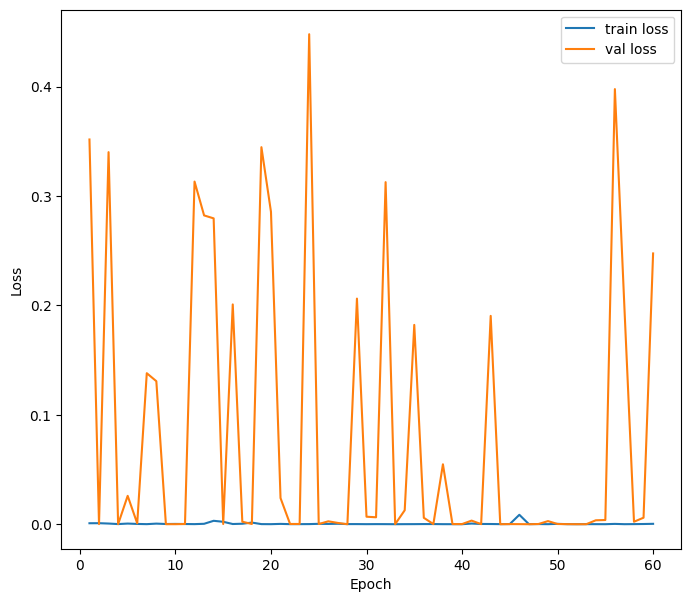

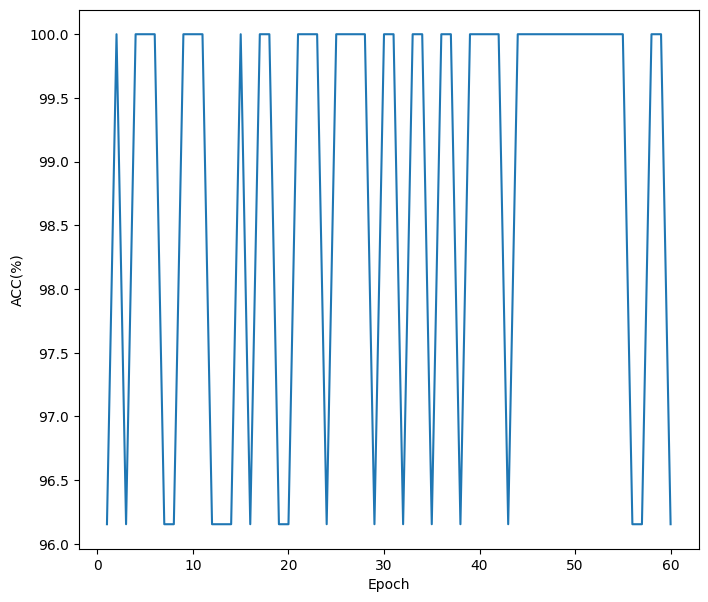

In [9]:
import matplotlib.pyplot as plt

# 시각화
x = np.arange(base+1,hy_epoch+1,step=1)
plt.figure(figsize=(8,7))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,all_train_loss,label='train loss')
plt.plot(x,all_val_loss,label='val loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
plt.xlabel('Epoch')
plt.ylabel('ACC(%)')
plt.plot(x,all_val_acc)
plt.show()

In [16]:
def plotImages(images, labels, predict):
    plt.figure(figsize=(20,8))
    to_image = transforms.ToPILImage()
    cnt=1

    for idx, item in enumerate(predict):
        if item != labels[idx]:
            image = images[idx]
            image = to_image(image)
            plt.subplot(2,6,cnt)
            plt.title('predict: {}(label: {})'.format(item,labels[idx]))
            plt.imshow(image,cmap='gray')
            cnt = cnt+1

Test accuracy of the pre-trained VGG16 on the 66 test images: 87.87878787878788%
Pre-trained VGG16
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.89      0.80      0.84        20
           2       0.77      0.85      0.81        20

    accuracy                           0.88        66
   macro avg       0.87      0.87      0.87        66
weighted avg       0.88      0.88      0.88        66

Pre-trained VGG16
[[25  0  1]
 [ 0 16  4]
 [ 1  2 17]]


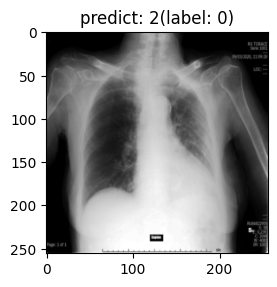

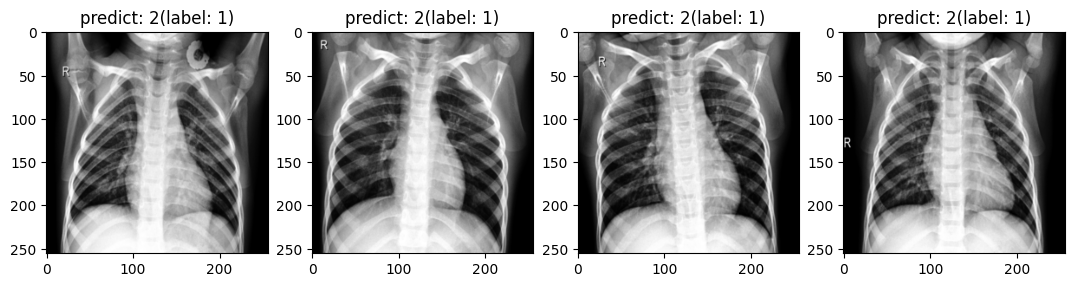

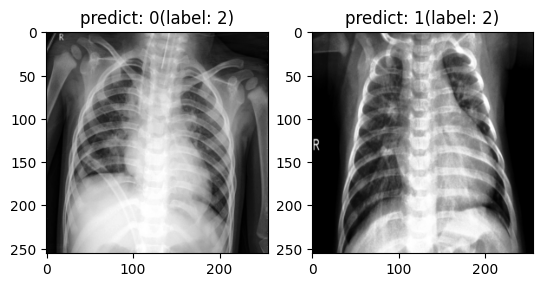

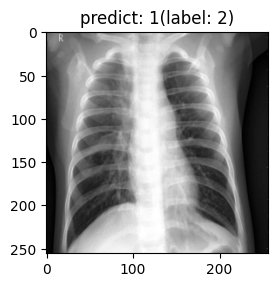

In [17]:
#inference
true_labels = []
pre_labels = []

model = torch.load(PATH+'cee_weights2/model_52.pt')
model.load_state_dict(torch.load(PATH+'cee_weights2/model_state_52.pt'))
checkpoint = torch.load(PATH+'cee_weights2/min_all_52.tar')
model.load_state_dict(checkpoint['model'])


with torch.no_grad():
    model.eval()

    correct = 0
    total = len(test_loader.dataset)
    for item in test_loader:
        images = item['image']
        labels = item['label']

        outputs = model(images)
        _, predict = torch.max(outputs,1)
        correct += (predict==labels).sum().item()
        true_labels.extend(labels)
        pre_labels.extend(predict)
        plotImages(images, labels, predict)
    
    print('Test accuracy of the pre-trained VGG16 on the {} test images: {}%'.format(total, 100*correct/total))

true_labels = torch.tensor(true_labels)
true_labels = true_labels.tolist()
pre_labels = torch.tensor(pre_labels)
pre_labels = pre_labels.tolist()

print('Pre-trained VGG16')
print(classification_report(true_labels,pre_labels))

print('Pre-trained VGG16')
print(confusion_matrix(true_labels,pre_labels))